# Assignment 2.1: Feed-Forward Neural Network
Student Name 1: ...

Student Name 2: ...

Student Name 3: ...

## German Traffic Sign Benchmark

In [1]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id=1De6T4b6mtFQALtuyT05zxGkS1YHKXG01" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1De6T4b6mtFQALtuyT05zxGkS1YHKXG01" -O FullIJCNN2013.zip && rm -rf /tmp/cookies.txt
!unzip FullIJCNN2013.zip

--2020-02-23 17:17:15--  https://docs.google.com/uc?export=download&confirm=LOzI&id=1De6T4b6mtFQALtuyT05zxGkS1YHKXG01
Resolving docs.google.com (docs.google.com)... 173.194.69.113, 173.194.69.138, 173.194.69.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.69.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ogqr3ea9f10p0t82s5bm498n6t35ge53/1582478100000/10074339115415534186/*/1De6T4b6mtFQALtuyT05zxGkS1YHKXG01?e=download [following]
--2020-02-23 17:17:15--  https://doc-0g-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ogqr3ea9f10p0t82s5bm498n6t35ge53/1582478100000/10074339115415534186/*/1De6T4b6mtFQALtuyT05zxGkS1YHKXG01?e=download
Resolving doc-0g-7k-docs.googleusercontent.com (doc-0g-7k-docs.googleusercontent.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Connecting to doc-0g-7k-docs.googleusercontent.co

In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

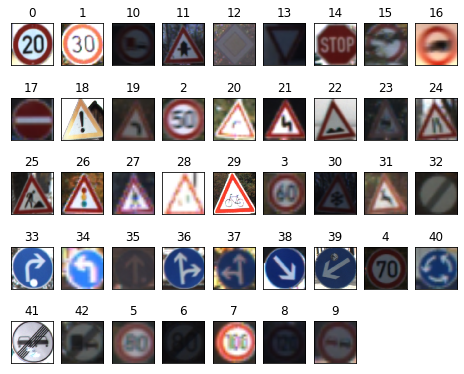

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 
np.random.seed(1996)

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

# Normalize the images to be values in range [0, 1]
tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
# Converts a class vector (integers) to binary class matrix
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

mlp = Sequential()
mlp.add(Flatten(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
mlp.add(Activation('relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(512))
mlp.add(Activation('relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(512))
mlp.add(Activation('relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(num_classes))
mlp.add(Activation('softmax'))

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
#opt = optimizers.Adam(lr=0.001, decay=1e-6)
mlp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
mlp.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
activation_1 (Activation)    (None, 150528)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               77070848  
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         

In [8]:
# Set callback functions to early stop training and save the best model so far
#callbacks = [EarlyStopping(monitor='val_loss', patience=2),
#             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

data = mlp.fit(tr_signs, tr_labels, batch_size=16, epochs=100, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = mlp.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('ffNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 600 samples, validate on 252 samples







Epoch 1/100
 - 3s - loss: 3.6533 - acc: 0.1100 - val_loss: 3.3238 - val_acc: 0.1944

Epoch 2/100
 - 1s - loss: 3.2990 - acc: 0.1550 - val_loss: 3.2060 - val_acc: 0.2024
Epoch 3/100
 - 1s - loss: 3.0737 - acc: 0.2067 - val_loss: 3.0425 - val_acc: 0.2500
Epoch 4/100
 - 1s - loss: 2.9002 - acc: 0.2317 - val_loss: 2.8422 - val_acc: 0.2500
Epoch 5/100
 - 1s - loss: 2.7016 - acc: 0.3233 - val_loss: 2.7702 - val_acc: 0.3254
Epoch 6/100
 - 1s - loss: 2.6188 - acc: 0.3250 - val_loss: 2.8069 - val_acc: 0.2778
Epoch 7/100
 - 1s - loss: 2.5170 - acc: 0.3450 - val_loss: 2.5063 - val_acc: 0.3690
Epoch 8/100
 - 1s - loss: 2.3849 - acc: 0.3783 - val_loss: 2.4503 - val_acc: 0.3730
Epoch 9/100
 - 1s - loss: 2.2350 - acc: 0.4333 - val_loss: 2.3485 - val_acc: 0.3968
Epoch 10/100
 - 1s - loss: 2.2048 - acc: 0.4233 - val_loss: 2.2873 - val_acc: 0.4405
Epoch 11

Test loss: 3.6197668120801616 - Accuracy: 0.7146814406083232

# CIFAR 100 Dataset

In [9]:
from keras.datasets import cifar100
(_x_train, _y_train), (_x_test, _y_test) = cifar100.load_data(label_mode='fine')


169009152/169001437 [==============================] - 6s 0us/step


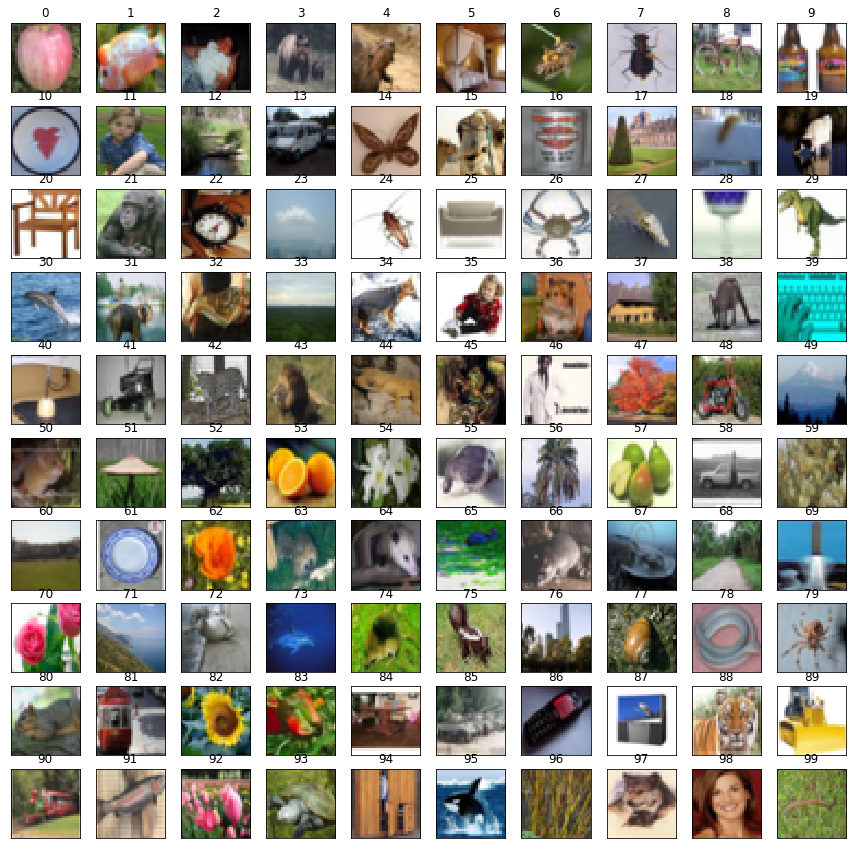

In [10]:
# Show examples from each class
class_names = np.unique(_y_train)
num_classes = len(class_names)

fig, axes = plt.subplots(10, 10,figsize=(15,15))
for i in range(num_classes):
    ax = axes.flatten()[i]
    indices = np.where(np.isin(_y_train, class_names[i]))[0]
    ax.imshow(_x_train[int(np.random.choice(indices, 1))])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(i)
plt.show()

In [0]:
# Data pre-processing
x_val = _x_train[40000:]
y_val = _y_train[40000:]
x_train = _x_train[:40000]
y_train = _y_train[:40000]
x_test = _x_test
y_test = _y_test

# Normalize the images to be values in range [0, 1]
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_val /= 255.0
x_test /= 255.0

from keras.utils import np_utils
# Converts a class vector (integers) to binary class matrix
tr_labels = np_utils.to_categorical(y_train, num_classes)
va_labels = np_utils.to_categorical(y_val, num_classes)
te_labels = np_utils.to_categorical(y_test, num_classes)

CIFAR_SIZE = (32, 32)

In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers

mlp = Sequential()
mlp.add(Flatten(input_shape=(CIFAR_SIZE[0], CIFAR_SIZE[1], 3)))
mlp.add(Activation('relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(512, activation='relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(512, activation='relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(num_classes))
mlp.add(Activation('softmax'))

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
mlp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
activation_5 (Activation)    (None, 3072)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)              

In [14]:
data = mlp.fit(x_train, tr_labels, batch_size=16, epochs=100, verbose=2, validation_data=(x_val, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = mlp.evaluate(x_test, te_labels, verbose=0)
end = time()
print('ffNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
 - 9s - loss: 4.3454 - acc: 0.0455 - val_loss: 4.0471 - val_acc: 0.0888
Epoch 2/100
 - 9s - loss: 4.0211 - acc: 0.0844 - val_loss: 3.8475 - val_acc: 0.1152
Epoch 3/100
 - 9s - loss: 3.8846 - acc: 0.1061 - val_loss: 3.7418 - val_acc: 0.1314
Epoch 4/100
 - 10s - loss: 3.7896 - acc: 0.1223 - val_loss: 3.6651 - val_acc: 0.1518
Epoch 5/100
 - 9s - loss: 3.7200 - acc: 0.1329 - val_loss: 3.6141 - val_acc: 0.1604
Epoch 6/100
 - 9s - loss: 3.6583 - acc: 0.1435 - val_loss: 3.5564 - val_acc: 0.1631
Epoch 7/100
 - 9s - loss: 3.6009 - acc: 0.1554 - val_loss: 3.4968 - val_acc: 0.1810
Epoch 8/100
 - 9s - loss: 3.5557 - acc: 0.1649 - val_loss: 3.4682 - val_acc: 0.1890
Epoch 9/100
 - 9s - loss: 3.5126 - acc: 0.1707 - val_loss: 3.4401 - val_acc: 0.1847
Epoch 10/100
 - 9s - loss: 3.4768 - acc: 0.1764 - val_loss: 3.3995 - val_acc: 0.1948
Epoch 11/100
 - 10s - loss: 3.4408 - acc: 0.1823 - val_loss: 3.3719 - val_acc: 0.2016
Epoch 12/100
 - 10s - 